In [1]:
# ipmrot libraries
import torch
from torch import nn
import numpy as np 
print(torch.__version__)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

1.13.0.dev20220907


In [2]:
# set up Spark
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.memory.offHeap.enabled","true") \
    .config("spark.memory.offHeap.size","30g")\
    .appName("GenericAppName") \
    .getOrCreate()

print("APP Name :"+ spark.sparkContext.appName);
print("Master :"+ spark.sparkContext.master);

sqlContext = SQLContext(spark.sparkContext)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/14 17:52:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/14 17:52:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/12/14 17:52:29 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/12/14 17:52:29 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/12/14 17:52:29 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
APP Name :GenericAppName
Master :local[*]


/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
# read in data

data_train_path = 'emnist/emnist-balanced-train.csv'
data_test_path = 'emnist/emnist-balanced-test.csv'

df_train = spark.read.csv(data_train_path, header = False, inferSchema = True)
df_test = spark.read.csv(data_test_path, header = False, inferSchema = True)

In [4]:
import numpy as np

col_nums = np.linspace(0,783, 784, dtype='int')
feature_col_names = list(map(lambda n: 'col_'+str(n), col_nums))

all_cols_names = ['outcome'] + feature_col_names

df_train = df_train.toDF(*all_cols_names)
df_test = df_test.toDF(*all_cols_names)

In [5]:
# remove all lowercase letters to keep only digits and uppercase letters
df_train = df_train.where(df_train['outcome'] < 36)
df_test = df_test.where(df_test['outcome'] < 36)


In [6]:
# develop PySpark pipeline to vectorize features

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml import Pipeline, Transformer

class ColumnDropper(Transformer):
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop

    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df


def get_process_pipeline():
    stage_vector_assembler = VectorAssembler(inputCols=feature_col_names, outputCol="features")
    
    column_dropper = ColumnDropper(columns_to_drop = list(feature_col_names))
    
    pipeline = Pipeline(stages=[stage_vector_assembler, column_dropper])
    
    return pipeline

process_pipeline = get_process_pipeline()

In [7]:
# fit and transform training data
process_pipeline_fitted = process_pipeline.fit(df_train)
train_transform = process_pipeline_fitted.transform(df_train)

In [8]:
# transform testing data
test_transform = process_pipeline_fitted.transform(df_test)

In [9]:
# split testing data to get validation data
test_transform_validate, test_transform = test_transform.randomSplit([0.5, 0.5])

In [11]:
# create Torch Dataset
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset): 
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return (self.x[idx],self.y[idx])
    

train = MyDataset(np.array(train_transform.toPandas()['features'].values.tolist()),
                  np.array(train_transform.toPandas()['outcome'].values.tolist()))

22/12/14 18:12:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [12]:
validate = MyDataset(np.array(test_transform_validate.toPandas()['features'].values.tolist()),
                  np.array(test_transform_validate.toPandas()['outcome'].values.tolist()))

In [13]:
# define multiclass nn
from torch import nn

class myNN(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.sequential = nn.Sequential(  
            nn.Linear(input_dim,410),
            nn.ReLU(),
            nn.Linear(410,410),
            nn.ReLU(),
            nn.Linear(410,output_dim)
        )
    def forward(self,x):
        y = self.sequential(x)
        return y
    
mymodel = myNN(784,36) 

print(mymodel)

myNN(
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=410, bias=True)
    (1): ReLU()
    (2): Linear(in_features=410, out_features=410, bias=True)
    (3): ReLU()
    (4): Linear(in_features=410, out_features=36, bias=True)
  )
)


In [14]:
# load our own dataset
df_own = spark.read.csv('our_own_splits.csv', header = True, inferSchema = True)

In [15]:
df_own_transform = process_pipeline_fitted.transform(df_own)


In [16]:
own = MyDataset(np.array(test_transform.toPandas()['features'].values.tolist()),
                  np.array(test_transform.toPandas()['outcome'].values.tolist()))

In [17]:
# train
lr = 0.0001
batch_size = 20
num_epochs = 20


train_dataloader = DataLoader(train, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validate, batch_size = batch_size, shuffle = False)
own_dataloader = DataLoader(own,batch_size = batch_size,shuffle = False)


# for accuracy calcuations
from sklearn import metrics

def training(mymodel, lr = lr, batch_size  = batch_size, num_epochs = num_epochs):
    
    optimizer = torch.optim.SGD(mymodel.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    hyperparameters = {'lr': lr, 'batch_size': batch_size, 'num_epochs': num_epochs}
    
    train_batch_losses = []
    losses = []
    validation_losses = []
    
    own_losses = []
    accuracies = []
    
    validation_accuracies = []
    own_accuracies = []

    
    criterion = nn.CrossEntropyLoss()
    
    print('# Epochs: '+str(num_epochs))
    print('Batch Size: '+str(batch_size))
    print('Learning Rate: '+str(lr)+'\n\n')
    
    for n in range(num_epochs):
    
        batch_losses = []
        batch_accuracies = []
        for x_b, y_b in train_dataloader:

            pred = mymodel(x_b.float())

            loss = criterion(pred, y_b.long())
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            # append loss and accuracy
            batch_losses.append(loss.detach().numpy())
            batch_accuracies.append(metrics.accuracy_score(y_b, torch.argmax(pred,1)))            
            train_batch_losses.append(loss.detach().numpy())
            
        validate_batch_losses = []
        validate_batch_models = []
        validate_batch_accuracies = []
        for x_vb, y_vb in validate_dataloader:

            pred = mymodel(x_vb.float())
            validate_batch_models.append(pred)
            
            # calculate loss
            loss = criterion(pred, y_vb.long())


            # append loss and accuracy 
            validate_batch_losses.append(loss.detach().numpy())
            validate_batch_accuracies.append(metrics.accuracy_score(y_vb, torch.argmax(pred,1)))
            
        own_batch_losses = []
        own_batch_models = []
        own_batch_accuracies = []
        for x_ob, y_ob in own_dataloader:

            pred = mymodel(x_ob.float())
            own_batch_models.append(pred)
            
            # calculate loss
            loss = criterion(pred, y_ob.long())


            # append loss and accuracy 
            own_batch_losses.append(loss.detach().numpy())
            own_batch_accuracies.append(metrics.accuracy_score(y_ob, torch.argmax(pred,1)))       
        
        
        
        losses.append(np.mean(batch_losses))
        accuracies.append(np.mean(batch_accuracies))
        validation_losses.append(np.mean(validate_batch_losses))
        validation_accuracies.append(np.mean(validate_batch_accuracies))
        own_losses.append(np.mean(own_batch_losses))
        own_accuracies.append(np.mean(own_batch_accuracies))
        
        print('Epoch '+str(n+1)+':')
        print('Train Loss: '+str(np.mean(batch_losses)))
        print('Train Accuracy: '+str(np.mean(batch_accuracies)))
        print('\nValidation Loss: '+str(np.mean(validate_batch_losses)))
        print('Validation Accuracy: '+str(np.mean(validate_batch_accuracies))+'\n')
        print('\nOwn Loss: '+str(np.mean(own_batch_losses)))
        print('Own Accuracy: '+str(np.mean(own_batch_accuracies))+'\n')
        
        
        if validation_accuracies[-1] == np.max(validation_accuracies):
            print('This is the best model so far. Saving model.\n\n')
            torch.save(mymodel.state_dict(), 'current_best_model')
        
    return hyperparameters, losses, train_batch_losses, validation_losses, accuracies, validation_accuracies, own_losses, own_accuracies

hyperparameters, losses, train_batch_losses, validation_losses, accuracies, validation_accuracies, own_losses, own_accuracies = training(mymodel)

# Epochs: 20
Batch Size: 20
Learning Rate: 0.0001


Epoch 1:
Train Loss: 1.7220685
Train Accuracy: 0.5930555555555556

Validation Loss: 1.0330346
Validation Accuracy: 0.7075342465753425


Own Loss: 1.0960971
Own Accuracy: 0.6943352059925094

This is the best model so far. Saving model.


Epoch 2:
Train Loss: 0.8706872
Train Accuracy: 0.7437962962962963

Validation Loss: 0.82791865
Validation Accuracy: 0.753013698630137


Own Loss: 0.8861588
Own Accuracy: 0.7489700374531835

This is the best model so far. Saving model.


Epoch 3:
Train Loss: 0.70460904
Train Accuracy: 0.7855555555555557

Validation Loss: 0.7580172
Validation Accuracy: 0.7658904109589041


Own Loss: 0.8092738
Own Accuracy: 0.7597690387016229

This is the best model so far. Saving model.


Epoch 4:
Train Loss: 0.6109764
Train Accuracy: 0.8095949074074074

Validation Loss: 0.67359805
Validation Accuracy: 0.7905479452054794


Own Loss: 0.73118186
Own Accuracy: 0.7879993757802745

This is the best model so far. Saving model.

No handles with labels found to put in legend.


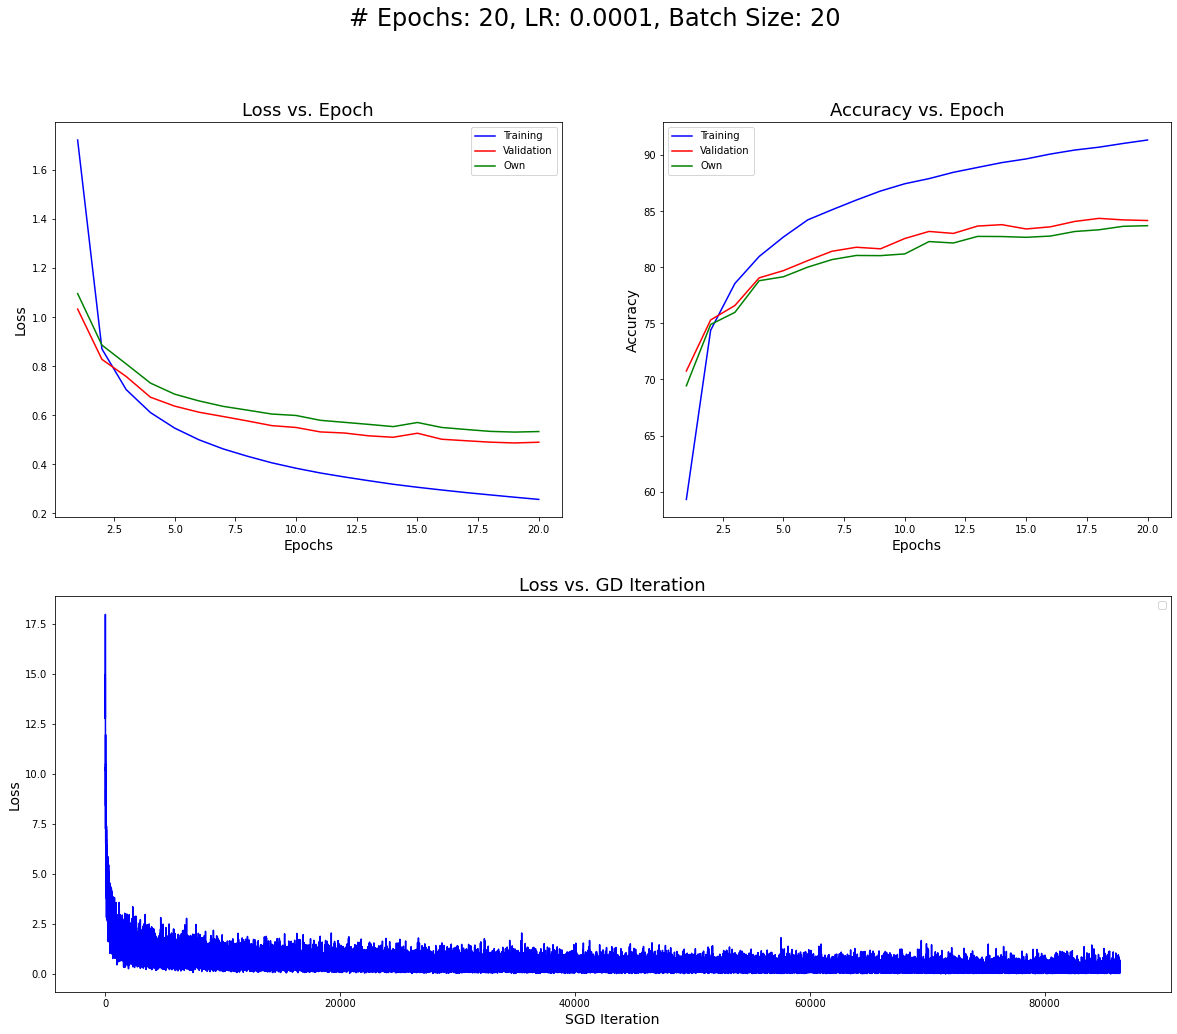

In [18]:
# plot
def plot_metrics(hyperparameters, losses, train_batch_losses, validation_losses, accuracies, validation_accuracies, own_losses, own_accuracies):
    epochs = np.arange(1, len(losses) + 1)
    
    gs = gridspec.GridSpec(2,2)
    
    fig = plt.figure()
    fig.suptitle(f"# Epochs: {hyperparameters['num_epochs']}, LR: {hyperparameters['lr']}, Batch Size: {hyperparameters['batch_size']}"
                  , fontsize = 24)
    fig.set_size_inches(20, 16)
    
    # plot loss vs. epoch
    ax = plt.subplot(gs[0,0])
    plt.plot(epochs, losses, c = 'b', label = 'Training')
    plt.plot(epochs, validation_losses, c = 'r', label = 'Validation')
    plt.plot(epochs, own_losses, c = 'g', label = 'Own')
    plt.title('Loss vs. Epoch', fontsize=18)
    plt.xlabel('Epochs', fontsize =14)
    plt.ylabel('Loss', fontsize = 14)
    plt.legend()
    
    # plot accuracy vs. epoch
    ax = plt.subplot(gs[0,1])
    ax.plot(epochs, np.array(accuracies) * 100, c = 'b', label = 'Training')
    ax.plot(epochs, np.array(validation_accuracies) * 100, c = 'r', label = 'Validation')
    ax.plot(epochs, np.array(own_accuracies) * 100, c = 'g', label = 'Own')
    plt.title('Accuracy vs. Epoch', fontsize=18)
    plt.xlabel('Epochs', fontsize =14)
    plt.ylabel('Accuracy', fontsize = 14)
    plt.legend()
    
    # plot loss vs. sgd iteration
    ax = plt.subplot(gs[1,:])
    ax.plot(np.arange(1, len(train_batch_losses)+1), train_batch_losses, c = 'b')
    plt.title('Loss vs. GD Iteration', fontsize=18)
    plt.xlabel('SGD Iteration', fontsize =14)
    plt.ylabel('Loss', fontsize = 14)
    plt.legend()
    
    # save figure
    fig.savefig(f"Epochs_{hyperparameters['num_epochs']}_LR_{hyperparameters['lr']}_Batch_{hyperparameters['batch_size']}.png", bbox_inches='tight')
    
    
plot_metrics(hyperparameters, losses, train_batch_losses, validation_losses, accuracies, validation_accuracies, own_losses, own_accuracies)

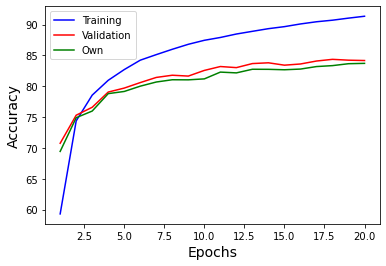

In [28]:
epochs = np.arange(1, len(losses) + 1)
plt.plot(epochs, np.array(accuracies) * 100, c = 'b', label = 'Training')
plt.plot(epochs, np.array(validation_accuracies) * 100, c = 'r', label = 'Validation')
plt.plot(epochs, np.array(own_accuracies) * 100, c = 'g', label = 'Own')
plt.xlabel('Epochs', fontsize =14)
plt.ylabel('Accuracy', fontsize = 14)
plt.legend()
plt.savefig(f"Accuracy Epochs_{hyperparameters['num_epochs']}_LR_{hyperparameters['lr']}_Batch_{hyperparameters['batch_size']}.png", bbox_inches='tight')

In [26]:
# print final accuracies
print('Train Accuracy: '+str(accuracies[-1]))
print('Validate Accuracy: '+str(validation_accuracies[-1]) + ' (using Test Set)')
print('Own Accuracy: '+str(own_accuracies[-1]))

Train Accuracy: 0.9134027777777779
Validate Accuracy: 0.8416438356164383 (using Test Set)
Own Accuracy: 0.8370474406991261


In [101]:
# load best model and evaluate on test dataset
batch_size = 20

mybestmodel = myNN(784,36)
mybestmodel.load_state_dict(torch.load('current_best_model'))

own_accuracies_test = []

for x_b, y_b in own_dataloader:
    pred = mybestmodel(x_b.float())
    own_accuracies_test.append(metrics.accuracy_score(y_b, torch.argmax(pred,1)))
    
print('Test Accuracy: '+str(np.mean(own_accuracies_test)))

Test Accuracy: 0.8650969529085871


# Tuning

## Dropout

In [24]:
# defining dropout nn
from torch import nn

class myNN_dropout(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.sequential = nn.Sequential(  
            nn.Linear(input_dim,410),
            nn.ReLU(),
            nn.Linear(410,410),
            nn.Dropout(0.20),
            nn.ReLU(),
            nn.Linear(410,output_dim)
        )
    def forward(self,x):
        y = self.sequential(x)
        return y
    
dropout_model = myNN_dropout(784,36) 

print(dropout_model)

myNN_dropout(
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=410, bias=True)
    (1): ReLU()
    (2): Linear(in_features=410, out_features=410, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=410, out_features=36, bias=True)
  )
)


In [25]:
# train with dropout
dropo_hyperparameters, dropo_losses, dropo_train_batch_losses, dropo_validation_losses, dropo_accuracies, dropo_validation_accuracies, dropo_own_losses, dropo_own_accuracies = training(dropout_model)

# Epochs: 20
Batch Size: 20
Learning Rate: 0.0001


Epoch 1:
Train Loss: 2.1238296
Train Accuracy: 0.5107638888888889

Validation Loss: 1.258971
Validation Accuracy: 0.6390410958904109


Own Loss: 1.311168
Own Accuracy: 0.6331616729088639

This is the best model so far. Saving model.


Epoch 2:
Train Loss: 1.0932547
Train Accuracy: 0.6817361111111111

Validation Loss: 1.0054911
Validation Accuracy: 0.7004109589041096


Own Loss: 1.0445497
Own Accuracy: 0.7010611735330836

This is the best model so far. Saving model.


Epoch 3:
Train Loss: 0.9016518
Train Accuracy: 0.7292939814814815

Validation Loss: 0.8977534
Validation Accuracy: 0.7263013698630137


Own Loss: 0.9308472
Own Accuracy: 0.7253745318352058

This is the best model so far. Saving model.


Epoch 4:
Train Loss: 0.80137825
Train Accuracy: 0.7541435185185186

Validation Loss: 0.8145663
Validation Accuracy: 0.7475342465753425


Own Loss: 0.8616047
Own Accuracy: 0.7450374531835207

This is the best model so far. Saving model.


E

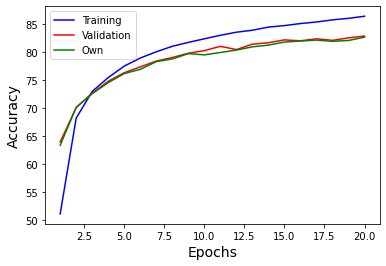

In [27]:
epochs = np.arange(1, len(dropo_losses) + 1)
plt.plot(epochs, np.array(dropo_accuracies) * 100, c = 'b', label = 'Training')
plt.plot(epochs, np.array(dropo_validation_accuracies) * 100, c = 'r', label = 'Validation')
plt.plot(epochs, np.array(dropo_own_accuracies) * 100, c = 'g', label = 'Own')
plt.xlabel('Epochs', fontsize =14)
plt.ylabel('Accuracy', fontsize = 14)
plt.legend()
plt.savefig(f"Dropout Accuracy Epochs_{hyperparameters['num_epochs']}_LR_{hyperparameters['lr']}_Batch_{hyperparameters['batch_size']}.png", bbox_inches='tight')

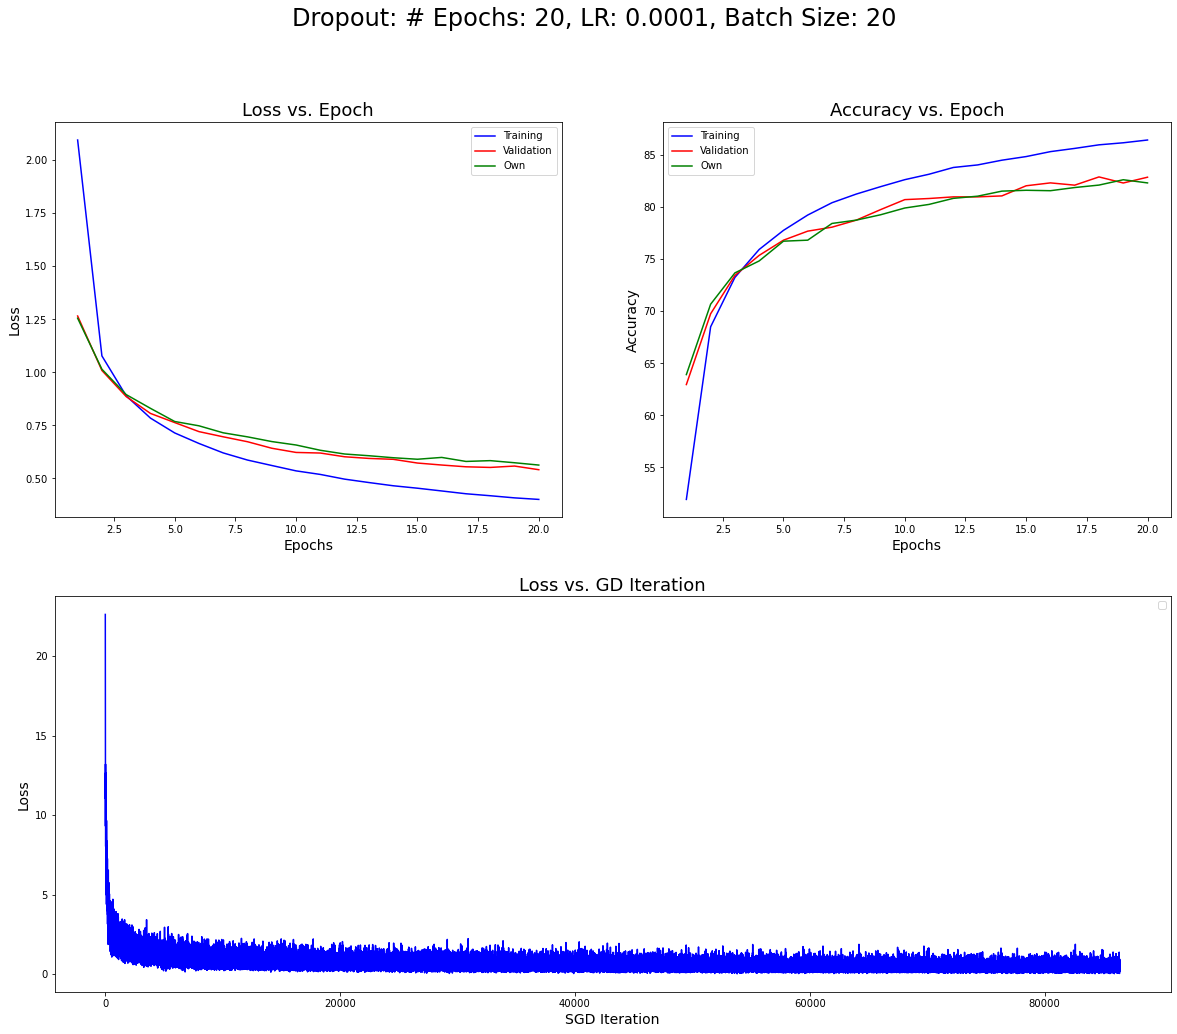

In [116]:
# plot dropout
def plot_metrics_dropout(hyperparameters, losses, train_batch_losses, validation_losses, accuracies, validation_accuracies, own_losses, own_accuracies):
    epochs = np.arange(1, len(losses) + 1)
    
    gs = gridspec.GridSpec(2,2)
    
    fig = plt.figure()
    fig.suptitle(f"Dropout: # Epochs: {hyperparameters['num_epochs']}, LR: {hyperparameters['lr']}, Batch Size: {hyperparameters['batch_size']}"
                  , fontsize = 24)
    fig.set_size_inches(20, 16)
    
    # plot loss vs. epoch
    ax = plt.subplot(gs[0,0])
    plt.plot(epochs, losses, c = 'b', label = 'Training')
    plt.plot(epochs, validation_losses, c = 'r', label = 'Validation')
    plt.plot(epochs, own_losses, c = 'g', label = 'Own')
    plt.title('Loss vs. Epoch', fontsize=18)
    plt.xlabel('Epochs', fontsize =14)
    plt.ylabel('Loss', fontsize = 14)
    plt.legend()
    
    # plot accuracy vs. epoch
    ax = plt.subplot(gs[0,1])
    ax.plot(epochs, np.array(accuracies) * 100, c = 'b', label = 'Training')
    ax.plot(epochs, np.array(validation_accuracies) * 100, c = 'r', label = 'Validation')
    ax.plot(epochs, np.array(own_accuracies) * 100, c = 'g', label = 'Own')
    plt.title('Accuracy vs. Epoch', fontsize=18)
    plt.xlabel('Epochs', fontsize =14)
    plt.ylabel('Accuracy', fontsize = 14)
    plt.legend()
    
    # plot loss vs. sgd iteration
    ax = plt.subplot(gs[1,:])
    ax.plot(np.arange(1, len(train_batch_losses)+1), train_batch_losses, c = 'b')
    plt.title('Loss vs. GD Iteration', fontsize=18)
    plt.xlabel('SGD Iteration', fontsize =14)
    plt.ylabel('Loss', fontsize = 14)
    plt.legend()
    
    # save figure
    fig.savefig(f"Dropout Epochs_{hyperparameters['num_epochs']}_LR_{hyperparameters['lr']}_Batch_{hyperparameters['batch_size']}.png", bbox_inches='tight')
    
    
plot_metrics_dropout(dropo_hyperparameters, dropo_losses, dropo_train_batch_losses, dropo_validation_losses, dropo_accuracies, dropo_validation_accuracies, dropo_own_losses, dropo_own_accuracies)

In [57]:
# print dropout final accuracies
print('Dropout')
print('Train Accuracy: '+str(dropo_accuracies[-1]))
print('Validate Accuracy: '+str(dropo_validation_accuracies[-1]) + ' (using Test Set)')
print('Own Accuracy: '+str(dropo_own_accuracies[-1]))

Dropout
Train Accuracy: 0.802488425925926
Validate Accuracy: 0.7839930555555554 (using Test Set)
Own Accuracy: 0.7810249307479226


## Hyperparameter Tuning

In [29]:
# tune
lr_arr = [0.001, 0.0015, 0.003]
batch_size_arr = [50, 100, 200]

hp_accuracies = []

for lr in lr_arr:
    for batch_size in batch_size_arr:

        run_name = 'Learning Rate: '+str(lr)+' Batch Size: '+str(batch_size)
        print('')
        #print('---Current Run: '+run_name+'---')
        print('------')
        hyperparameters, losses, train_batch_losses, validation_losses,accuracies, validation_accuracies, own_losses, own_accuracies = training(mymodel, lr = lr,
                                                                                batch_size = batch_size)
        
        hp_accuracies.append(own_accuracies[-1])
        
        if np.max(hp_accuracies) == own_accuracies[-1]:
            torch.save(mymodel.state_dict(), 'current_best_model_hpt')
            best_run_name = run_name
            print('New Best Model:', best_run_name)




------
# Epochs: 20
Batch Size: 50
Learning Rate: 0.001


Epoch 1:
Train Loss: 0.46732304
Train Accuracy: 0.8410416666666667

Validation Loss: 0.5396772
Validation Accuracy: 0.8328767123287671


Own Loss: 0.5782067
Own Accuracy: 0.827356429463171

This is the best model so far. Saving model.


Epoch 2:
Train Loss: 0.3559097
Train Accuracy: 0.8741550925925927

Validation Loss: 0.48370275
Validation Accuracy: 0.8480821917808218


Own Loss: 0.5155589
Own Accuracy: 0.843492509363296

This is the best model so far. Saving model.


Epoch 3:
Train Loss: 0.2971619
Train Accuracy: 0.8906597222222222

Validation Loss: 0.47885776
Validation Accuracy: 0.8410958904109589


Own Loss: 0.512529
Own Accuracy: 0.8359082397003745

Epoch 4:
Train Loss: 0.25592098
Train Accuracy: 0.902164351851852

Validation Loss: 0.47509983
Validation Accuracy: 0.8495890410958905


Own Loss: 0.50077385
Own Accuracy: 0.843789013732834

This is the best model so far. Saving model.


Epoch 5:
Train Loss: 0.222153
Train Acc

In [30]:
# evaluate with best model
mybestmodel_hp = myNN(784,36)
mybestmodel_hp.load_state_dict(torch.load('current_best_model_hpt'))

own_accuracies_hpt = []

for x_b, y_b in own_dataloader:
    pred = mybestmodel_hp(x_b.float())
    own_accuracies_hpt.append(metrics.accuracy_score(y_b, torch.argmax(pred,1)))

print('Best Model: '+str(best_run_name))
print('Test Accuracy: '+str(np.mean(own_accuracies_hpt)))

Best Model: Learning Rate: 0.001 Batch Size: 50
Test Accuracy: 0.865980024968789


In [32]:
# print all tuning accuracies
i = 0
for lr in lr_arr:
    for batch_size in batch_size_arr:
        print('Learning Rate: '+str(lr)+' & Batch Size: '+str(batch_size)+': '+str(hp_accuracies[i]))
        i += 1
    print('\n')

Learning Rate: 0.001 & Batch Size: 50: 0.865980024968789
Learning Rate: 0.001 & Batch Size: 100: 0.85853620474407
Learning Rate: 0.001 & Batch Size: 200: 0.8624687890137328


Learning Rate: 0.0015 & Batch Size: 50: 0.8596598002496877
Learning Rate: 0.0015 & Batch Size: 100: 0.8533395755305868
Learning Rate: 0.0015 & Batch Size: 200: 0.8648720349563046


Learning Rate: 0.003 & Batch Size: 50: 0.8478776529338327
Learning Rate: 0.003 & Batch Size: 100: 0.8530586766541822
Learning Rate: 0.003 & Batch Size: 200: 0.8295880149812733


